<a href="https://colab.research.google.com/github/PalakShaikh/face-recog/blob/main/FACE_RECOGNITION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from IPython.display import Image


def take_photo(filename='_name_/photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])

  with open(filename, 'wb') as f:
    f.write(binary)
  return filename


Enter the Person's Name: VAJ
Taking pictures...
Give multiple expressions


<IPython.core.display.Javascript object>

Saved to VAJ/photo0.jpg


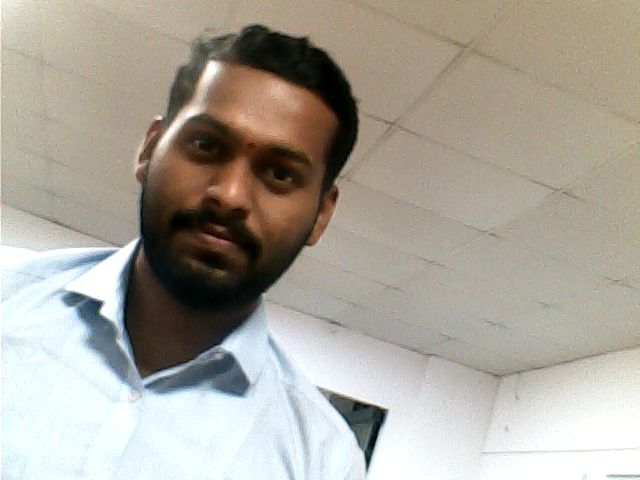

<IPython.core.display.Javascript object>

Saved to VAJ/photo0.jpg


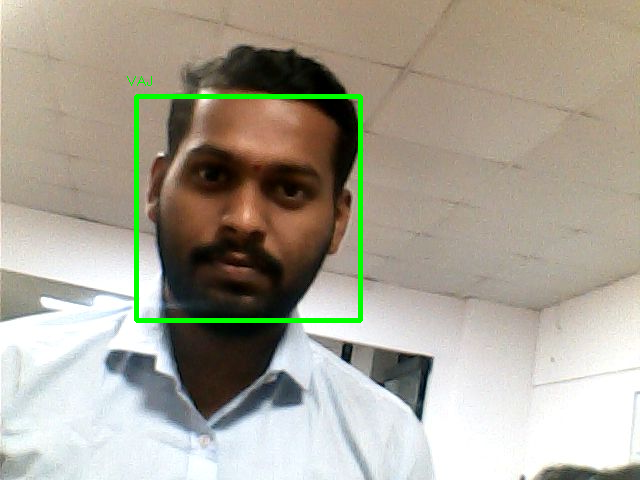

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [13]:
import cv2, sys, numpy, os, time
from google.colab.patches import cv2_imshow
count = 0
size = 4
fn_haar = 'haarcascade_frontalface_default.xml'
fn_dir = 'database'
fn_name = input("Enter the Person's Name: ")
path = os.path.join(fn_dir, fn_name)
if not os.path.isdir(fn_name):
    os.makedirs(fn_name, exist_ok=True)
if not os.path.isdir(path):
    os.makedirs(path, exist_ok=True)
(im_width, im_height) = (112, 92)
haar_cascade = cv2.CascadeClassifier(fn_haar)

print("Taking pictures...")
print("Give multiple expressions")

#Take 50 pictures per person
while count < 50:
    filename = take_photo(filename=fn_name+'/photo'+str(count)+'.jpg')
    print('Saved to {}'.format(filename))
    im = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
    im = cv2.flip(im, 1, 0)
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    mini = cv2.resize(gray,(gray.shape[1]//size, gray.shape[0]//size))
    faces = haar_cascade.detectMultiScale(mini)
    faces = sorted(faces, key=lambda x: x[3])
    if faces:
        face_i = faces[0]
        (x, y, w, h) = [v * size for v in face_i]
        face = gray[y:y + h, x:x + w]
        face_resize = cv2.resize(face, (im_width, im_height))
        pin=sorted([int(n[:n.find('.')]) for n in os.listdir(path)
               if n[0]!='.' ]+[0])[-1] + 1
        cv2.imwrite('%s/%s.png' % (path, pin), face_resize)
        cv2.rectangle(im, (x, y), (x + w, y + h), (0, 255, 0), 3)
        cv2.putText(im, fn_name, (x - 10, y - 10), cv2.FONT_HERSHEY_PLAIN,
            1,(0, 255, 0))
        time.sleep(0.38)
        count += 1
    cv2_imshow(im)
    time.sleep(3)
print(str(count) + " images taken and saved to " + fn_name +" folder in database ")


In [ ]:
import cv2, sys, os
import numpy as np
from IPython.display import display
import ipywidgets as widgets
from PIL import Image

size = 4
haar_file = 'haarcascade_frontalface_default.xml'
datasets = 'database'

print('Training...')

# Create a list of images and a list of corresponding names
(images, lables, names, id) = ([], [], {}, 0)
for (subdirs, dirs, files) in os.walk(datasets):
    for subdir in dirs:
        if subdir!='.ipynb_checkpoints':
            print(subdir)
            names[id] = subdir
            subjectpath = os.path.join(datasets, subdir)
            for filename in os.listdir(subjectpath):
              path = os.path.join(subjectpath, filename)
              i = cv2.imread(path, 0)
              if i is not None and filename!= '.ipynb_checkpoints':
                  lable = id
                  images.append(i)
                  lables.append(int(lable))
              else:
                  print(filename)
            id += 1
(width, height) = (130, 100)

# Create a Numpy array from the two lists above
(images, lables) = [numpy.array(lis) for lis in [images, lables]]

#OpenCV trains a model from the images
#NOTE FOR OpenCV2: remove '.face'
model = cv2.face.LBPHFaceRecognizer_create()
model.train(images, lables)

face_cascade = cv2.CascadeClassifier(haar_file)

In [ ]:
#JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "Status:";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '' +
          'When finished, click here or on the video to stop this demo';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
import PIL
import io
import base64

# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(base64.b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
import cv2
import numpy as np
from IPython.display import display
import ipywidgets as widgets
from PIL import Image

# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0
while True:
    # Read a frame from the video stream
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    im = js_to_image(js_reply["img"])

    # Process the frame as desired
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    for (x, y, w, h) in faces:
        cv2.rectangle(im, (x, y), (x + w, y + h), (255, 0, 0), 2)
        face = gray[y:y + h, x:x + w]
        face_resize = cv2.resize(face, (width, height))
        # Try to recognize the face
        prediction = model.predict(face_resize)

        if prediction[1] > 80:
            bbox_array = cv2.rectangle(bbox_array, (x, y), (x + w, y + h), (0, 255, 0), 3)
            bbox_array = cv2.putText(bbox_array , '%s - %.0f' % (names[prediction[0]], prediction[1]), (x - 10, y - 10),
                        cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0))
        else:
            bbox_array = cv2.rectangle(bbox_array, (x, y), (x + w, y + h), (255, 0, 0), 3)
            bbox_array = cv2.putText(bbox_array, 'not recognized', (x - 10, y - 10), cv2.FONT_HERSHEY_PLAIN, 2, (255, 0, 0))
    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    bbox_bytes = bbox_to_bytes(bbox_array)
    bbox = bbox_bytes

In [ ]:
import cv2
import numpy as np
from IPython.display import display
import ipywidgets as widgets
from PIL import Image


#Create path for output images
outpath = '/content/Output'
if not os.path.isdir(outpath):
    os.makedirs(outpath, exist_ok=True)


# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0
while True:
    # Read a frame from the video stream
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    im = js_to_image(js_reply["img"])

    # Process the frame as desired
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    for (x, y, w, h) in faces:
        cv2.rectangle(im, (x, y), (x + w, y + h), (255, 0, 0), 2)
        face = gray[y:y + h, x:x + w]
        face_resize = cv2.resize(face, (width, height))
        # Try to recognize the face
        prediction = model.predict(face_resize)
        cv2.rectangle(im, (x, y), (x + w, y + h), (0, 255, 0), 3)

        if prediction[1] > 97:
            cv2.putText(im, '%s - %.0f' % (names[prediction[0]], prediction[1]), (x - 10, y - 10),
                        cv2.FONT_HERSHEY_PLAIN, 1, (0, 255, 0))
        else:
            cv2.putText(im, 'not recognized', (x - 10, y - 10), cv2.FONT_HERSHEY_PLAIN, 1, (255, 0, 0))
    cv2.imwrite('%s/0ut%s.png' % (outpath, count), im)
    cv2_imshow(im)
    count+=1
    if cv2.waitKey(1) & 0xFF ==ord('q'):
        break